In [136]:
import numpy as np
import random
import os
import datetime as dt
import pandas as pd

from collections import deque, OrderedDict, namedtuple
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from BackTestPackage import UniverseData, BackTestModule

In [48]:
start_date = '1990-01-01'
end_date = dt.date.today().strftime('%Y-%m-%d')


yfinance_list = ['^GSPC']



testUniverse = UniverseData(sdate = start_date, edate = end_date)
testUniverse.update_yfinance(yfinance_list)
testUniverse.data_df['cash'] = [1 for item in list(testUniverse.data_df.index)]

In [49]:
testUniverse.data_df.apply(np.log).diff()

,^GSPC,cash
Date,,
1990-01-02,NaN,NaN
1990-01-03,-0.002589,0.0
1990-01-04,-0.008650,0.0
1990-01-05,-0.009804,0.0
1990-01-08,0.004504,0.0
...,...,...
2021-05-10,-0.010490,0.0
2021-05-11,-0.008712,0.0
2021-05-12,-0.021683,0.0


In [398]:
WINDOW = 120
SUB_WINDOW = 20

class Market():
    def __init__(self, data_df):
        self.data_df = data_df
        self.return_df = data_df.apply(np.log).diff()
        
        self.date_list = list(data_df.index)
        self.date = self.date_list[WINDOW+1]
        
        self.actions = [0, 1, 2]
        self.wgt = [0.5]
    
    def next_date(self):
        date_idx = self.date_list.index(self.date)
        self.date = self.date_list[date_idx+1]
        
    def observe(self):
        date_idx = self.date_list.index(self.date)
        return list(100*self.return_df.iloc[date_idx-WINDOW:date_idx].values.reshape(WINDOW))
    
    def reset(self):
        self.date = self.date_list[WINDOW+1]
        self.wgt = [0.5]
        self.update_state()
        
        return self.state
        
    def update_state(self):
        obs = self.observe()
        mean = np.mean(obs)
        stdev = np.std(obs)
        sub_mean = np.mean(obs[-SUB_WINDOW:])
        sub_stdev = np.std(obs[-SUB_WINDOW:])
        self.state = list(self.wgt + [mean, stdev] + [sub_mean, sub_stdev] )
        self.state = np.array(self.state)
    
    def get_log_return(self):
        stock_return = np.exp(self.return_df.loc[self.date].values[0])
        
        total_return = (self.wgt[0]*stock_return + (1-self.wgt[0]))
        
        if total_return < 0 : total_return = 1
        
        return np.log(total_return)
    
    def step(self, action):
        
        is_done = (self.date == self.date_list[-1])
        
        state = self.state
        reward = self.get_log_return()
        
        stock_return = np.exp(self.return_df.loc[self.date].values[0])
        stock_asset = self.wgt[0] * stock_return
        cash_asset = 1-self.wgt[0]
        
        wgt_before = stock_asset / (stock_asset + cash_asset)
        
        if action == 0:
            wgt_now = wgt_before
        elif action == 1:
            wgt_now = np.min([1, wgt_before + 0.05])
        elif action == 2:
            wgt_now = np.max([0, wgt_before - 0.05])
        
        self.wgt = [wgt_now]
        
        #reward -= 0.001*np.abs(wgt_before-wgt_now)
        
        if is_done == False:
            self.next_date()
            next_state = self.update_state()
            
        self.state = np.array(self.state)
        
        return {'next_state':self.state, 'reward':reward, 'is_done':is_done}
            
        
        

In [399]:
testenv = Market(testUniverse.data_df[['^GSPC']])
testenv.reset()
print(testenv.state)
testenv.step(1)
print(testenv.state)

[ 0.5        -0.00992854  0.82188695 -0.04174645  0.88121403]
[ 0.5477958  -0.0151185   0.82540154 -0.03211245  0.8708646 ]


In [400]:
class Agent():
    def __init__(self, state_size, action_size, seed):
        self.buffer_size = 100000
        self.batch_size = 1024
        self.gamma = 1.
        self.tau = 0.01
        self.lr = 10**(-4.5)
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        
        self.qnetwork_local = QNetwork(state_size, action_size, seed)
        self.qnetwork_target = QNetwork(state_size, action_size, seed)
        self.qnetwork_target.eval()
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = self.lr)
        
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, seed)
        
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step += 1
        
        if self.t_step%4 == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)
                
    def act(self, state, eps):
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0)
            self.qnetwork_local.eval()
            with torch.no_grad():
                action_values = self.qnetwork_local(state)
            self.qnetwork_local.train()
            
            action = np.argmax(action_values.cpu().data.numpy())
            
        else:
            action = random.choice(np.arange(self.action_size))
            
        return action
    
    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        
        with torch.no_grad():
            next_action_rewards_local = self.qnetwork_local(next_states)
            greedy_action_local = next_action_rewards_local.max(dim = 1, keepdim = True)[1]
            
            next_action_rewards_target = self.qnetwork_target(next_states)
            target_rewards = next_action_rewards_target.gather(1, greedy_action_local)
            
            target_rewards = rewards + (self.gamma * target_rewards * (1 - dones))
            
        expected_action_rewards = self.qnetwork_local(states) 
        expected_rewards = expected_action_rewards.gather(1, actions) 
        
        loss = F.mse_loss(expected_rewards, target_rewards)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        for target_param, local_param in zip(
            self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
            
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
        

class ReplayBuffer():
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",
            field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        new_exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(new_exp)
        
    def sample(self):
        experiences = random.sample(self.memory, k = self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

In [401]:
def training(max_epi, max_t, eps_max, eps_min, eps_decay):
    score_list = []
    score_mean_list = []
    score_window = deque(maxlen = 5)
    eps = eps_max
    
    for epi in range(max_epi):
        state = env.reset()
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps).astype(int)
            env_info = env.step(action)
            
            next_state = env_info['next_state']
            reward = env_info['reward']
            done = env_info['is_done']
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            
            if done : break
                
        score_list.append(score)
        score_window.append(score)
        score_mean_list.append(np.mean(score_window))
        
        eps = max(eps_min, eps * eps_decay)
        
        if epi % 1 == 0:
            print(epi, score_mean_list[-1], eps)
        
        #if len(score_mean_list) > 10:
        #    if score_mean_list[-1] < score_mean_list[-2] and score_mean_list[-2] < score_mean_list[-3]:
        #        break
            
    return score_list, score_mean_list

In [402]:

env = Market(testUniverse.data_df[['^GSPC']])
env.reset()

state_size = len(env.state)
action_size = len(env.actions)


agent = Agent(state_size=state_size, action_size=action_size, seed=0)
scores, mean = training(max_epi=50, max_t=10000, eps_max=0.5, eps_min=0.01, eps_decay=0.9)


0 0.5196914307069161 0.45
1 0.9942951549567853 0.405
2 1.2625003999996232 0.36450000000000005
3 1.3743757731867952 0.32805000000000006
4 1.4787225434484703 0.2952450000000001
5 1.7780014761871286 0.2657205000000001
6 1.860909583206317 0.23914845000000007
7 1.951875137512691 0.21523360500000008
8 2.0134193625321744 0.19371024450000007
9 2.047269704038519 0.17433922005000008
10 2.0572219294943634 0.15690529804500009
11 2.158089155361245 0.14121476824050008
12 2.1270756671493922 0.12709329141645007
13 2.14672567265862 0.11438396227480506
14 2.1822583099733155 0.10294556604732455
15 2.2051269140769527 0.0926510094425921
16 2.2597985517679495 0.08338590849833288
17 2.2977108115625593 0.0750473176484996
18 2.379372093731031 0.06754258588364964
19 2.4000274808137356 0.06078832729528468
20 2.426353347183139 0.05470949456575622
21 2.3374574321178856 0.0492385451091806
22 2.368442921805841 0.04431469059826254
23 2.3719371423731337 0.039883221538436285
24 2.3908123372162153 0.03589489938459266
25

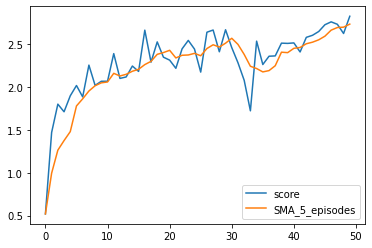

In [413]:
plt.plot(scores)
plt.plot(mean)
plt.legend(['score','SMA_5_episodes'])

In [404]:
env.reset()
wgt_list = []
action_list = []
while True:
    action = agent.act(env.state,eps=0)
    action_list.append(action)
    env_info = env.step(action)
    wgt_list += env.wgt
    if env_info['is_done'] : break

([<matplotlib.patches.Wedge at 0x2f109120a90>,
 [Text(0.5877440215703084, 0.9298155543484746, 'no transaction'),
  Text(-0.8344752748531444, -0.7166945065080164, 'stock +5%'),
  Text(1.0516832533779505, -0.3224319068646431, 'stock -5%')])

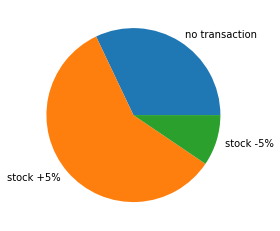

In [405]:
action_dic = {x:action_list.count(x) for x in action_list}
plt.pie([action_dic[x] for x in range(3)] ,labels =['no transaction','stock +5%','stock -5%']  )

In [406]:
target_df = pd.DataFrame({'^GSPC':wgt_list, 'cash':[1-x for x in wgt_list]},index = env.date_list[WINDOW+1:])
target_df

,^GSPC,cash
1990-06-25,0.497796,0.502204
1990-06-26,0.497618,0.502382
1990-06-27,0.549796,0.450204
1990-06-28,0.551525,0.448475
1990-06-29,0.551794,0.448206
...,...,...
2021-05-10,0.900296,0.099704
2021-05-11,0.949512,0.050488
2021-05-12,0.998462,0.001538
2021-05-13,0.948480,0.051520


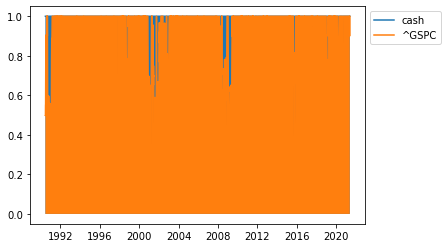

In [407]:
universe_list = ['^GSPC','cash']
def cum_wgt_df(idx):
    return sum([target_df[universe_list[x]] for x in range(idx+1)])

for idx in range(len(universe_list)):
    df = cum_wgt_df(len(universe_list) - idx - 1)
    plt.plot(df)
    plt.fill_between(df.index, df.values)

plt.legend(universe_list[::-1], bbox_to_anchor=(1.0, 1.0))

In [408]:
testBackTest = BackTestModule(testUniverse)

asset_df, wgt_df = testBackTest.run_backtest(target_df=target_df, sdate='1990-01-01', edate='2023-01-01', rebal_period=1, 
                                            sub_portfolio = 1)


1990-06-25 00:00:00 2021-05-14 00:00:00


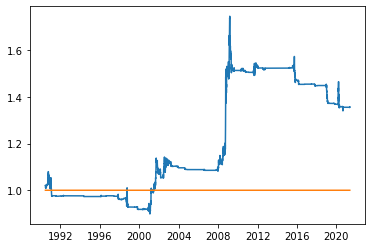

In [409]:
plt.plot(asset_df['asset']/testUniverse.data_df['^GSPC']*testUniverse.data_df['^GSPC'][0])
plt.plot(asset_df['asset']/asset_df['asset'])


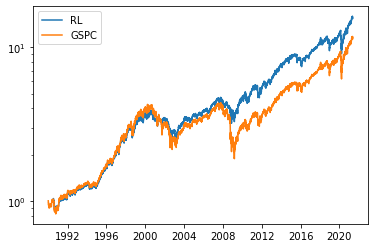

In [410]:
plt.plot(asset_df)
plt.plot(testUniverse.data_df[['^GSPC']]/testUniverse.data_df[['^GSPC']].iloc[0])
plt.legend(['RL','GSPC'])
plt.yscale('log')